# 第9章: RNN, CNN

## 80. ID番号への変換
問題51で構築した学習データ中の単語にユニークなID番号を付与したい．学習データ中で最も頻出する単語に1，2番目に頻出する単語に2，……といった方法で，学習データ中で2回以上出現する単語にID番号を付与せよ．そして，与えられた単語列に対して，ID番号の列を返す関数を実装せよ．ただし，出現頻度が2回未満の単語のID番号はすべて0とせよ．

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader

In [ ]:
!nvidia-smi

Wed Jun 22 13:43:36 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 435.21       Driver Version: 435.21       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:18:00.0 Off |                  N/A |
| 29%   43C    P8    10W / 250W |     10MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:3B:00.0 Off |                  N/A |
| 23%   30C    P8     8W / 250W |     10MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [ ]:
# 51で作った特徴量を使うよりも出現頻度が二回未満の物をはじいて作ったほうが早そう
train = pd.read_csv("data/train.txt", header=None, sep="\t")
valid = pd.read_csv("data/valid.txt", header=None, sep="\t")
test = pd.read_csv("data/test.txt", header=None, sep="\t")

# 2個以上出現し、１文字の単語を省かない設定
vectorizer = CountVectorizer(min_df=2, token_pattern=u'(?u)\\b\\w+\\b')

# titleを全て小文字に変える
train_title = train[0].str.lower()

# ベクトル化
bag = vectorizer.fit_transform(train_title).toarray()

total = bag.sum(axis=0)
# ソートしたインデックスを用いるためargsort
idx = np.argsort(total)[::-1]

# ソート順位をそれぞれ辞書化
words = np.array(vectorizer.get_feature_names())[idx]
word2id = defaultdict(int)
for cnt, word in enumerate(words):
    word2id[word] = cnt+1

# id番号の列を返す関数
def get_id(sentence):
    id_list = []
    sen = sentence.split()
    for word in sen:
        word = word.lower()
        if word2id[word]:
            id_list.append(word2id[word])
        else:
            id_list.append(0)
    return id_list

C:\Users\kotem\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
text = train[0][1]
print(text)
print("テキストid列:", get_id(text))

FOREX-Dollar rises on US rate speculation after Yellen comments
テキストid列: [0, 100, 7, 10, 115, 1145, 18, 132, 359]


## 81. RNNによる予測
d_w=300, d_h=50

In [ ]:
print(len(word2id))

7575


In [ ]:
class RNN(nn.Module):
    def __init__(self, vocab_size, emb_size, hidden_size, output_size):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_size, padding_idx=0)
        self.rnn = nn.RNN(emb_size, hidden_size, nonlinearity="tanh", batch_first=True) # batch_first 入力を(バッチサイズ、時系列の数、入力の数)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x, h=None):
        x = self.emb(x)
        x, h = self.rnn(x, h)
        x = x[:, -1]
        x = self.fc(x)
        return x

vocab_size = len(word2id) + 1 # 0を足したid番号数
emb_size = 300 # d_w=300
hidden_size = 50 # d_h=50
output_size = 4 # 4分類

In [ ]:
# データセットを受け取ってID化したtensorを返す
from torch.utils.data import Dataset

class CreateDataset(Dataset):
    def __init__(self, X, Y, get_id):
        self.X = X
        self.Y = Y
        self.get_id = get_id

    def __len__(self):  # len(Dataset)で返す値を指定
        return len(self.Y)
    
    def __getitem__(self, index):
        text = self.X[index]
        input = get_id(text)

        return {
            "input": torch.tensor(input, dtype=torch.int64),
            "label": torch.tensor(self.Y[index], dtype=torch.int64)
        }

In [ ]:
x_train = train[0]
# yのラベルを置き換える
category_dict = {'b': 0, 't': 1, 'e':2, 'm':3}
y_train = train[1].map(lambda x: category_dict[x]).values

train_dataset = CreateDataset(x_train, y_train, get_id)
print(train_dataset[0])


{'input': tensor([ 218, 2846,  489,  623,    0,  157,    1,  969]), 'label': tensor(0)}


In [ ]:
x_valid = valid[0]
# yのラベルを置き換える
category_dict = {'b': 0, 't': 1, 'e':2, 'm':3}
y_valid = valid[1].map(lambda x: category_dict[x]).values

valid_dataset = CreateDataset(x_valid, y_valid, get_id)

x_test = test[0]
# yのラベルを置き換える
category_dict = {'b': 0, 't': 1, 'e':2, 'm':3}
y_test = valid[1].map(lambda x: category_dict[x]).values

test_dataset = CreateDataset(x_test, y_test, get_id)

In [ ]:
model = RNN(vocab_size, emb_size, hidden_size, output_size)
for i in range(10):
    X = train_dataset[i]["input"]
    print(torch.softmax(model(X.unsqueeze(0)), dim=-1))

tensor([[0.1401, 0.2271, 0.2690, 0.3639]], grad_fn=<SoftmaxBackward>)
tensor([[0.2293, 0.2515, 0.3025, 0.2166]], grad_fn=<SoftmaxBackward>)
tensor([[0.2609, 0.2064, 0.1576, 0.3751]], grad_fn=<SoftmaxBackward>)
tensor([[0.2798, 0.2070, 0.2668, 0.2464]], grad_fn=<SoftmaxBackward>)
tensor([[0.2684, 0.2483, 0.2662, 0.2171]], grad_fn=<SoftmaxBackward>)
tensor([[0.1792, 0.2510, 0.2696, 0.3001]], grad_fn=<SoftmaxBackward>)
tensor([[0.2954, 0.2536, 0.1846, 0.2665]], grad_fn=<SoftmaxBackward>)
tensor([[0.3298, 0.3154, 0.2440, 0.1108]], grad_fn=<SoftmaxBackward>)
tensor([[0.2722, 0.1385, 0.3735, 0.2158]], grad_fn=<SoftmaxBackward>)
tensor([[0.2815, 0.2230, 0.3099, 0.1855]], grad_fn=<SoftmaxBackward>)


## 82. 確率的勾配降下法による学習
確率的勾配降下法（SGD: Stochastic Gradient Descent）を用いて，問題81で構築したモデルを学習せよ．訓練データ上の損失と正解率，評価データ上の損失と正解率を表示しながらモデルを学習し，適当な基準（例えば10エポックなど）で終了させよ．

In [ ]:
def cal_loss_acc(model, dataset, criterion=None):
    dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
    loss = 0.0
    total = 0
    correct = 0
    for data in dataloader:
        with torch.no_grad():
            output = model(data["input"]) # 順伝搬
            if criterion != None:
                loss += criterion(output, data["label"]) # 損失計算
            pred = torch.argmax(output, dim=-1)
            total += len(data["input"])
            correct += (pred == data["label"]).sum().item()
    return (loss/len(dataset)).item(), correct/total





def train(model, train_dataset, valid_dataset, epochs, batch_size, optimizer, criterion):
    dataloader_train = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    # 損失のログ
    record_loss_train = []
    record_loss_valid = []
    record_acc_train = []
    record_acc_valid = []
    for epoch in range(epochs):
        print(f"epoch:{epoch+1}")
        model.train()
        for data in dataloader_train:
            optimizer.zero_grad() # 勾配を0に
            output = model(data["input"])
            loss = criterion(output, data["label"])
            loss.backward()
            optimizer.step()

        model.eval()
        loss_train, acc_train = cal_loss_acc(model, train_dataset, criterion=criterion)
        loss_valid, acc_valid = cal_loss_acc(model, valid_dataset, criterion=criterion)
        record_loss_train.append(loss_train)
        record_loss_valid.append(loss_valid)
        record_acc_train.append(acc_train)
        record_acc_valid.append(acc_valid)
    return record_loss_train, record_loss_valid, record_acc_train, record_acc_valid

epoch:1
epoch:2
epoch:3
epoch:4
epoch:5
epoch:6
epoch:7
epoch:8
epoch:9
epoch:10


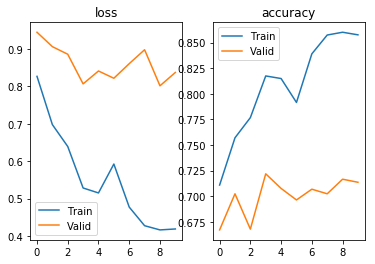

In [ ]:
model = RNN(vocab_size, emb_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)
record_loss_train, record_loss_valid, record_acc_train, record_acc_valid = train(model, train_dataset, valid_dataset, 10, 1, optimizer, criterion)
Figure = plt.figure()
ax1 = Figure.add_subplot(1,2,1)
ax2 = Figure.add_subplot(1,2,2)


ax1.plot(range(len(record_loss_train)), record_loss_train, label="Train")
ax1.plot(range(len(record_loss_valid)), record_loss_valid, label="Valid")
ax2.plot(range(len(record_acc_train)), record_acc_train, label="Train")
ax2.plot(range(len(record_acc_valid)), record_acc_valid, label="Valid")

ax1.set_title("loss")
ax2.set_title("accuracy")

ax1.legend()
ax2.legend()
plt.show()

## 83. ミニバッチ化・GPU上での学習
問題82のコードを改変し，B事例ごとに損失・勾配を計算して学習を行えるようにせよ（Bの値は適当に選べ）．また，GPU上で学習を実行せよ．

In [ ]:
# ミニバッチ化するには系列長をそろえる必要がある
class Padsequence():
    # 最大系列長でパディング
    def __init__(self, padding_idx):
        self.padding_idx = padding_idx

    def __call__(self, batch):
        sorted_batch = sorted(batch, key=lambda x: x["input"].shape[0], reverse=True)
        sequences = [x["input"] for x in  sorted_batch]
        sequences_padded = torch.nn.utils.rnn.pad_sequence(sequences, batch_first=True, padding_value=self.padding_idx)
        label = torch.LongTensor([x["label"] for x in sorted_batch])

        return {
            "input": sequences_padded,
            "label": label
            }

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

def cal_loss_acc(model, dataset, device, criterion=None):
    model = model.to(device)
    dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
    loss = 0.0
    total = 0
    correct = 0
    for data in dataloader:
        with torch.no_grad():
            input = data["input"].to(device)
            y = data["label"].to(device)
            output = model(input) # 順伝搬
            if criterion != None:
                loss += criterion(output, y) # 損失計算
            pred = torch.argmax(output, dim=-1)
            total += len(input)
            correct += (pred == y).sum().item()
    return (loss/len(dataset)).item(), correct/total

def train(model, train_dataset, valid_dataset, epochs, batch_size, optimizer, criterion, device, collate_fn=None):
    print(f"batch_size:{batch_size}")
    dataloader_train = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,collate_fn=collate_fn)
    model = model.to(device)
    max_acc = 0
    count = 0 # accが増えていないカウント
    for epoch in range(epochs):
        print(f"epoch:{epoch+1}")
        model.train()
        for data in dataloader_train:
            input = data["input"].to(device)
            y = data["label"].to(device)
            optimizer.zero_grad() # 勾配を0に
            output = model(input)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()

        model.eval()
        loss_train, acc_train = cal_loss_acc(model, train_dataset, device, criterion=criterion)
        loss_valid, acc_valid = cal_loss_acc(model, valid_dataset, device, criterion=criterion)
        print(f"loss_train:{loss_train} acc_train:{acc_train}")
        print(f"loss_valid:{loss_valid} acc_valid:{acc_valid}")
        if max_acc >= acc_valid:
            count += 1
        else:
          count = 0
        if count >= 3:
            break
        max_acc = max(max_acc, acc_valid)

In [ ]:
print(device)

cuda:0


In [ ]:
Batch_size = [2, 4, 8, 16, 32, 64, 128]
for batch_size in Batch_size:
    model = RNN(vocab_size, emb_size, hidden_size, output_size)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001)
    train(model, train_dataset, valid_dataset, 50, batch_size, optimizer, criterion, device, collate_fn=Padsequence(len(set(word2id.values()))))

batch_size:2
epoch:1
loss_train:1.1922214031219482 acc_train:0.46682908545727136
loss_valid:1.1950746774673462 acc_valid:0.452023988005997
epoch:2
loss_train:1.144595742225647 acc_train:0.49737631184407793
loss_valid:1.1572571992874146 acc_valid:0.48575712143928035
epoch:3
loss_train:1.1128098964691162 acc_train:0.5199587706146926
loss_valid:1.1360446214675903 acc_valid:0.5112443778110944
epoch:4
loss_train:1.0843466520309448 acc_train:0.5441341829085458
loss_valid:1.1195472478866577 acc_valid:0.5314842578710645
epoch:5
loss_train:1.0485708713531494 acc_train:0.571776611694153
loss_valid:1.097170352935791 acc_valid:0.5509745127436282
epoch:6
loss_train:1.0091643333435059 acc_train:0.600356071964018
loss_valid:1.0737888813018799 acc_valid:0.568215892053973
epoch:7
loss_train:0.9191073179244995 acc_train:0.654891304347826
loss_valid:0.9942349791526794 acc_valid:0.6266866566716641
epoch:8
loss_train:0.8472752571105957 acc_train:0.6986506746626686
loss_valid:0.9397184252738953 acc_valid:0.

loss_train:1.3250038623809814 acc_train:0.40695277361319343
loss_valid:1.3520134687423706 acc_valid:0.40104947526236884
epoch:12
loss_train:1.324375867843628 acc_train:0.40788980509745126
loss_valid:1.3528167009353638 acc_valid:0.3995502248875562
batch_size:16
epoch:1
loss_train:1.4226148128509521 acc_train:0.29685157421289354
loss_valid:1.4304548501968384 acc_valid:0.2863568215892054
epoch:2
loss_train:1.4135863780975342 acc_train:0.3068778110944528
loss_valid:1.4218692779541016 acc_valid:0.3020989505247376
epoch:3
loss_train:1.4061592817306519 acc_train:0.3214955022488756
loss_valid:1.4148163795471191 acc_valid:0.31259370314842577
epoch:4
loss_train:1.3995834589004517 acc_train:0.33667541229385306
loss_valid:1.4086726903915405 acc_valid:0.32608695652173914
epoch:5
loss_train:1.3930813074111938 acc_train:0.3479197901049475
loss_valid:1.4027405977249146 acc_valid:0.3335832083958021
epoch:6
loss_train:1.3877536058425903 acc_train:0.3608508245877061
loss_valid:1.3978946208953857 acc_vali

loss_train:1.4057763814926147 acc_train:0.37771739130434784
loss_valid:1.3912771940231323 acc_valid:0.37256371814092953
epoch:44
loss_train:1.405699610710144 acc_train:0.37818590704647675
loss_valid:1.39132559299469 acc_valid:0.37556221889055474
epoch:45
loss_train:1.4057376384735107 acc_train:0.3782796101949025
loss_valid:1.3916023969650269 acc_valid:0.3733133433283358
epoch:46
loss_train:1.405324101448059 acc_train:0.3787481259370315
loss_valid:1.3914369344711304 acc_valid:0.3740629685157421
epoch:47
loss_train:1.4057838916778564 acc_train:0.38052848575712145
loss_valid:1.3921502828598022 acc_valid:0.37556221889055474
batch_size:64
epoch:1
loss_train:1.461904525756836 acc_train:0.20605322338830584
loss_valid:1.4560481309890747 acc_valid:0.19790104947526238
epoch:2
loss_train:1.4597643613815308 acc_train:0.20830209895052473
loss_valid:1.4537639617919922 acc_valid:0.20239880059970014
epoch:3
loss_train:1.4585028886795044 acc_train:0.20970764617691154
loss_valid:1.4524731636047363 acc_v

## 84. 単語ベクトルの導入
事前学習済みの単語ベクトル（例えば，Google Newsデータセット（約1,000億単語）での学習済み単語ベクトル）で単語埋め込みemb(x)を初期化し，学習せよ．

In [ ]:
import torch
import torch.nn as nn
import numpy
import gensim

model_dir = 'data/GoogleNews-vectors-negative300.bin'
model_gm = gensim.models.KeyedVectors.load_word2vec_format(model_dir, binary=True)

In [ ]:
model = RNN(vocab_size, emb_size, hidden_size, output_size)
for word, word_id in word2id.items():
    if word in model_gm:
        model.emb.weight.data[word_id] = torch.tensor(model_gm[word])

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
def cal_loss_acc(model, dataset, device, criterion=None):
    model = model.to(device)
    dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
    loss = 0.0
    total = 0
    correct = 0
    for data in dataloader:
        with torch.no_grad():
            input = data["input"].to(device)
            y = data["label"].to(device)
            output = model(input) # 順伝搬
            if criterion != None:
                loss += criterion(output, y) # 損失計算
            pred = torch.argmax(output, dim=-1)
            total += len(input)
            correct += (pred == y).sum().item()
    return (loss/len(dataset)).item(), correct/total





def train(model, train_dataset, valid_dataset, epochs, batch_size, optimizer, criterion, device):
    dataloader_train = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    model = model.to(device)
    # 損失のログ
    record_loss_train = []
    record_loss_valid = []
    record_acc_train = []
    record_acc_valid = []
    for epoch in range(epochs):
        print(f"epoch:{epoch+1}")
        model.train()
        for data in dataloader_train:
            input = data["input"].to(device)
            y = data["label"].to(device)
            optimizer.zero_grad() # 勾配を0に
            output = model(input)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()

        model.eval()
        loss_train, acc_train = cal_loss_acc(model, train_dataset, device, criterion=criterion)
        loss_valid, acc_valid = cal_loss_acc(model, valid_dataset, device, criterion=criterion)
        record_loss_train.append(loss_train)
        record_loss_valid.append(loss_valid)
        record_acc_train.append(acc_train)
        record_acc_valid.append(acc_valid)
    return record_loss_train, record_loss_valid, record_acc_train, record_acc_valid

epoch:1
epoch:2
epoch:3
epoch:4
epoch:5
epoch:6
epoch:7
epoch:8
epoch:9
epoch:10


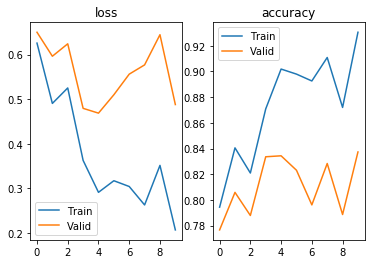

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)
record_loss_train, record_loss_valid, record_acc_train, record_acc_valid = train(model, train_dataset, valid_dataset, 10, 1, optimizer, criterion, device)
Figure = plt.figure()
ax1 = Figure.add_subplot(1,2,1)
ax2 = Figure.add_subplot(1,2,2)


ax1.plot(range(len(record_loss_train)), record_loss_train, label="Train")
ax1.plot(range(len(record_loss_valid)), record_loss_valid, label="Valid")
ax2.plot(range(len(record_acc_train)), record_acc_train, label="Train")
ax2.plot(range(len(record_acc_valid)), record_acc_valid, label="Valid")

ax1.set_title("loss")
ax2.set_title("accuracy")

ax1.legend()
ax2.legend()
plt.show()

## 85. 双方向RNN・多層化

In [ ]:
class RNN(nn.Module):
    def __init__(self, vocab_size, emb_size, hidden_size, output_size):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_size, padding_idx=0)
        self.rnn = nn.RNN(emb_size, hidden_size, bidirectional=True, nonlinearity="tanh", batch_first=True, ) # batch_first 入力を(バッチサイズ、時系列の数、入力の数)
        self.fc = nn.Linear(hidden_size *2, output_size)
    
    def forward(self, x, h=None):
        x = self.emb(x)
        x, h = self.rnn(x, h)
        x = x[:, -1]
        x = self.fc(x)
        return x

In [ ]:
model = RNN(vocab_size, emb_size, hidden_size, output_size)
for word, word_id in word2id.items():
    if word in model_gm:
        model.emb.weight.data[word_id] = torch.tensor(model_gm[word])

epoch:1
epoch:2
epoch:3
epoch:4
epoch:5
epoch:6
epoch:7
epoch:8
epoch:9
epoch:10


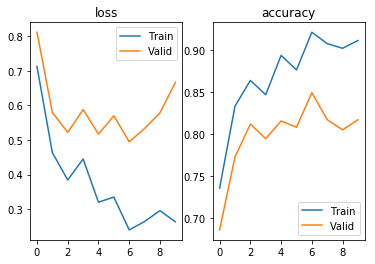

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)
record_loss_train, record_loss_valid, record_acc_train, record_acc_valid = train(model, train_dataset, valid_dataset, 10, 1, optimizer, criterion, device)
Figure = plt.figure()
ax1 = Figure.add_subplot(1,2,1)
ax2 = Figure.add_subplot(1,2,2)


ax1.plot(range(len(record_loss_train)), record_loss_train, label="Train")
ax1.plot(range(len(record_loss_valid)), record_loss_valid, label="Valid")
ax2.plot(range(len(record_acc_train)), record_acc_train, label="Train")
ax2.plot(range(len(record_acc_valid)), record_acc_valid, label="Valid")

ax1.set_title("loss")
ax2.set_title("accuracy")

ax1.legend()
ax2.legend()
plt.show()

多層化

In [ ]:
vocab_size = len(word2id) + 1 # 0を足したid番号数
emb_size = 300 # d_w=300
hidden_size = 50 # d_h=50
output_size = 4 # 4分類

class RNN(nn.Module):
    def __init__(self, vocab_size, emb_size, hidden_size, output_size):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_size, padding_idx=0)
        self.rnn1 = nn.RNN(emb_size, hidden_size, bidirectional=True, nonlinearity="tanh", batch_first=True, ) # batch_first 入力を(バッチサイズ、時系列の数、入力の数)
        self.rnn2 = nn.RNN(hidden_size *2, hidden_size, bidirectional=True, nonlinearity="tanh", batch_first=True, )
        self.rnn3 = nn.RNN(hidden_size *2, hidden_size, bidirectional=True, nonlinearity="tanh", batch_first=True, )
        self.fc = nn.Linear(hidden_size *2, output_size)
    
    def forward(self, x, h=None):
        x = self.emb(x)
        x, h = self.rnn1(x, h)
        x, h = self.rnn2(x, h)
        x, h = self.rnn3(x, h)
        x = x[:, -1]
        x = self.fc(x)
        return x

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

def cal_loss_acc(model, dataset, device, criterion=None):
    model = model.to(device)
    dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
    loss = 0.0
    total = 0
    correct = 0
    for data in dataloader:
        with torch.no_grad():
            input = data["input"].to(device)
            y = data["label"].to(device)
            output = model(input) # 順伝搬
            if criterion != None:
                loss += criterion(output, y) # 損失計算
            pred = torch.argmax(output, dim=-1)
            total += len(input)
            correct += (pred == y).sum().item()
    return (loss/len(dataset)).item(), correct/total

def train(model, train_dataset, valid_dataset, epochs, batch_size, optimizer, criterion, device, collate_fn=None):
    print(f"batch_size:{batch_size}")
    dataloader_train = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,collate_fn=collate_fn)
    # 損失のログ
    record_loss_train = []
    record_loss_valid = []
    record_acc_train = []
    record_acc_valid = []
    model = model.to(device)
    for epoch in range(epochs):
        print(f"epoch:{epoch+1}")
        model.train()
        for data in dataloader_train:
            input = data["input"].to(device)
            y = data["label"].to(device)
            optimizer.zero_grad() # 勾配を0に
            output = model(input)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()

        model.eval()
        loss_train, acc_train = cal_loss_acc(model, train_dataset, device, criterion=criterion)
        loss_valid, acc_valid = cal_loss_acc(model, valid_dataset, device, criterion=criterion)
        record_loss_train.append(loss_train)
        record_loss_valid.append(loss_valid)
        record_acc_train.append(acc_train)
        record_acc_valid.append(acc_valid)
    return record_loss_train, record_loss_valid, record_acc_train, record_acc_valid

In [ ]:
model = RNN(vocab_size, emb_size, hidden_size, output_size)
for word, word_id in word2id.items():
    if word in model_gm:
        model.emb.weight.data[word_id] = torch.tensor(model_gm[word])

batch_size:8
epoch:1
epoch:2
epoch:3
epoch:4
epoch:5
epoch:6
epoch:7
epoch:8
epoch:9
epoch:10


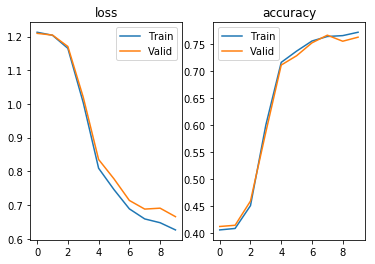

In [ ]:
batch_size = 8
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)
record_loss_train, record_loss_valid, record_acc_train, record_acc_valid = train(model, train_dataset, valid_dataset, 10, batch_size, optimizer, criterion, device, collate_fn=Padsequence(len(set(word2id.values()))))
Figure = plt.figure()
ax1 = Figure.add_subplot(1,2,1)
ax2 = Figure.add_subplot(1,2,2)


ax1.plot(range(len(record_loss_train)), record_loss_train, label="Train")
ax1.plot(range(len(record_loss_valid)), record_loss_valid, label="Valid")
ax2.plot(range(len(record_acc_train)), record_acc_train, label="Train")
ax2.plot(range(len(record_acc_valid)), record_acc_valid, label="Valid")

ax1.set_title("loss")
ax2.set_title("accuracy")

ax1.legend()
ax2.legend()
plt.show()

In [ ]:
batch_size = 8
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)
record_loss_train, record_loss_valid, record_acc_train, record_acc_valid = train(model, train_dataset, valid_dataset, 10, batch_size, optimizer, criterion, device, collate_fn=Padsequence(len(set(word2id.values()))))
Figure = plt.figure()
ax1 = Figure.add_subplot(1,2,1)
ax2 = Figure.add_subplot(1,2,2)


ax1.plot(range(len(record_loss_train)), record_loss_train, label="Train")
ax1.plot(range(len(record_loss_valid)), record_loss_valid, label="Valid")
ax2.plot(range(len(record_acc_train)), record_acc_train, label="Train")
ax2.plot(range(len(record_acc_valid)), record_acc_valid, label="Valid")

ax1.set_title("loss")
ax2.set_title("accuracy")

ax1.legend()
ax2.legend()
plt.show()
Figure.save("data/ans85_test")

batch_size:8
epoch:1
epoch:2
epoch:3
epoch:4
epoch:5


batch_size:1
epoch:1
epoch:2
epoch:3
epoch:4
epoch:5
epoch:6
epoch:7
epoch:8
epoch:9
epoch:10


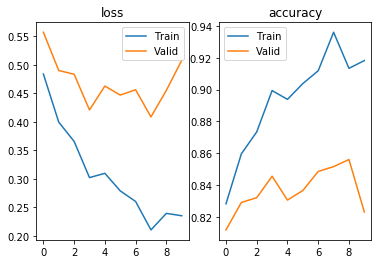

In [ ]:
batch_size = 1
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)
record_loss_train, record_loss_valid, record_acc_train, record_acc_valid = train(model, train_dataset, valid_dataset, 10, batch_size, optimizer, criterion, device, collate_fn=Padsequence(len(set(word2id.values()))))
Figure = plt.figure()
ax1 = Figure.add_subplot(1,2,1)
ax2 = Figure.add_subplot(1,2,2)


ax1.plot(range(len(record_loss_train)), record_loss_train, label="Train")
ax1.plot(range(len(record_loss_valid)), record_loss_valid, label="Valid")
ax2.plot(range(len(record_acc_train)), record_acc_train, label="Train")
ax2.plot(range(len(record_acc_valid)), record_acc_valid, label="Valid")

ax1.set_title("loss")
ax2.set_title("accuracy")

ax1.legend()
ax2.legend()
plt.show()

## 86. 畳み込みニューラルネットワーク (CNN)


* 単語埋め込みの次元数: dw
* 畳み込みのフィルターのサイズ: 3 トークン
* 畳み込みのストライド: 1 トークン
* 畳み込みのパディング: あり
* 畳み込み演算後の各時刻のベクトルの次元数:dh
* 畳み込み演算後に最大値プーリング（max pooling）を適用し，入力文をdh
次元の隠れベクトルで表現

参考　https://tkengo.github.io/blog/2016/03/11/understanding-convolutional-neural-networks-for-nlp/

In [ ]:
vocab_size = len(word2id) + 1 # 0を足したid番号数
emb_size = 300 # d_w=300
hidden_size = 50 # d_h=50
output_size = 4 # 4分類
max_len = len(x_train[0])

class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_size, padding_idx=0)
        self.conv = nn.Conv1d(emb_size, hidden_size, 3, padding=1)
        self.act = nn.ReLU()
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.emb(x)
        x = x.transpose(1, 2)
        x = self.conv(x)
        x = self.act(x)
        x = F.max_pool1d(x, x.size()[2])
        x = x.squeeze(2)
        x = self.fc(x)
        return x

## 87. 確率的勾配降下法によるCNNの学習
確率的勾配降下法（SGD: Stochastic Gradient Descent）を用いて，問題86で構築したモデルを学習せよ．訓練データ上の損失と正解率，評価データ上の損失と正解率を表示しながらモデルを学習し，適当な基準（例えば10エポックなど）で終了させよ．

epoch:1
epoch:51
epoch:101
epoch:151
epoch:201
epoch:251
epoch:301
epoch:351
epoch:401
epoch:451


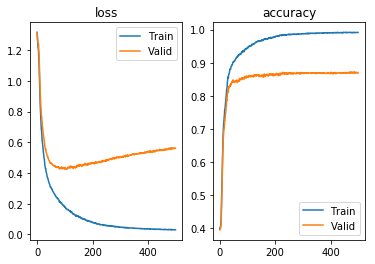

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

import torch
import torch.nn as nn
import numpy as np
import gensim

net = CNN().to(device)
for word, word_id in word2id.items():
    if word in model_gm:
        net.emb.weight.data[word_id] = torch.tensor(model_gm[word])
criterion = nn.CrossEntropyLoss()
batch_size = 64
dataloader_train = DataLoader(train_dataset, batch_size=batch_size,shuffle=True, collate_fn=Padsequence(len(set(word2id.values()))))
optimizer = optim.SGD(net.parameters(), lr=0.01)
net = net.to(device)
# 損失のログ
record_loss_train = []
record_loss_valid = []
record_acc_train = []
record_acc_valid = []
for epoch in range(500):
    if epoch % 50 == 0:
      print(f"epoch:{epoch+1}")
    net.train()
    for data in dataloader_train:
      input = data["input"].to(device)
      y = data["label"].to(device)
      optimizer.zero_grad()
      output = net(input)
      loss = criterion(output, y)
      loss.backward()
      optimizer.step()
    net.eval()
    loss_train, acc_train = cal_loss_acc(net, train_dataset, device, criterion=criterion)
    loss_valid, acc_valid = cal_loss_acc(net, valid_dataset, device, criterion=criterion)
    record_loss_train.append(loss_train)
    record_loss_valid.append(loss_valid)
    record_acc_train.append(acc_train)
    record_acc_valid.append(acc_valid)

Figure = plt.figure()
ax1 = Figure.add_subplot(1,2,1)
ax2 = Figure.add_subplot(1,2,2)


ax1.plot(range(len(record_loss_train)), record_loss_train, label="Train")
ax1.plot(range(len(record_loss_valid)), record_loss_valid, label="Valid")
ax2.plot(range(len(record_acc_train)), record_acc_train, label="Train")
ax2.plot(range(len(record_acc_valid)), record_acc_valid, label="Valid")

ax1.set_title("loss")
ax2.set_title("accuracy")

ax1.legend()
ax2.legend()
plt.show()



## 88. パラメータチューニング
問題85や問題87のコードを改変し，ニューラルネットワークの形状やハイパーパラメータを調整しながら，高性能なカテゴリ分類器を構築せよ．

双方向RNNの層を追加して、ハイパーパラメータは学習率、バッチサイズを変更して行う

In [ ]:
vocab_size = len(word2id) + 1 # 0を足したid番号数
emb_size = 300 # d_w=300
hidden_size = 50 # d_h=50
output_size = 4 # 4分類

class RNN(nn.Module):
    def __init__(self, vocab_size, emb_size, hidden_size, output_size):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_size, padding_idx=0)
        self.rnn1 = nn.RNN(emb_size, hidden_size, bidirectional=True, nonlinearity="tanh", batch_first=True, ) # batch_first 入力を(バッチサイズ、時系列の数、入力の数)
        self.rnn2 = nn.RNN(hidden_size *2, hidden_size, bidirectional=True, nonlinearity="tanh", batch_first=True, )
        self.rnn3 = nn.RNN(hidden_size *2, hidden_size, bidirectional=True, nonlinearity="tanh", batch_first=True, )
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(hidden_size *2, output_size)
    
    def forward(self, x, h=None):
        x = self.emb(x)
        x = self.dropout(x)
        x, h = self.rnn1(x, h)
        x, h = self.rnn2(x, h)
        x, h = self.rnn3(x, h)
        x = x[:, -1]
        x = self.fc(x)
        return x

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

def cal_loss_acc(model, dataset, device, criterion=None):
    model = model.to(device)
    dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
    loss = 0.0
    total = 0
    correct = 0
    for data in dataloader:
        with torch.no_grad():
            input = data["input"].to(device)
            y = data["label"].to(device)
            output = model(input) # 順伝搬
            if criterion != None:
                loss += criterion(output, y) # 損失計算
            pred = torch.argmax(output, dim=-1)
            total += len(input)
            correct += (pred == y).sum().item()
    return (loss/len(dataset)).item(), correct/total

def train(model, train_dataset, valid_dataset, epochs, batch_size, optimizer, criterion, device, collate_fn=None):
    print(f"batch_size:{batch_size}")
    dataloader_train = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,collate_fn=collate_fn)
    # 損失のログ
    record_loss_train = []
    record_loss_valid = []
    record_acc_train = []
    record_acc_valid = []
    model = model.to(device)
    for epoch in range(epochs):
        if epoch == 9:
            print(f"epoch:{epoch+1}")
        else:
            print(f"epoch:{epoch+1}",end=" ")
        model.train()
        for data in dataloader_train:
            input = data["input"].to(device)
            y = data["label"].to(device)
            optimizer.zero_grad() # 勾配を0に
            output = model(input)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()

        model.eval()
        loss_train, acc_train = cal_loss_acc(model, train_dataset, device, criterion=criterion)
        loss_valid, acc_valid = cal_loss_acc(model, valid_dataset, device, criterion=criterion)
        record_loss_train.append(loss_train)
        record_loss_valid.append(loss_valid)
        record_acc_train.append(acc_train)
        record_acc_valid.append(acc_valid)
    return record_loss_train, record_loss_valid, record_acc_train, record_acc_valid

In [ ]:
batch_size = [1, 8, 128]
LR = [0.0001, 0.001, 0.01, 0.1]
# epoch数は10

lr: 0.0001
batch_size:1
epoch:1 epoch:2 epoch:3 epoch:4 epoch:5 epoch:6 epoch:7 epoch:8 epoch:9 epoch:10
lr: 0.001
batch_size:1
epoch:1 epoch:2 epoch:3 epoch:4 epoch:5 epoch:6 epoch:7 epoch:8 epoch:9 epoch:10
lr: 0.01
batch_size:1
epoch:1 epoch:2 epoch:3 epoch:4 epoch:5 epoch:6 epoch:7 epoch:8 epoch:9 epoch:10
lr: 0.1
batch_size:1
epoch:1 epoch:2 epoch:3 epoch:4 epoch:5 epoch:6 epoch:7 epoch:8 epoch:9 epoch:10


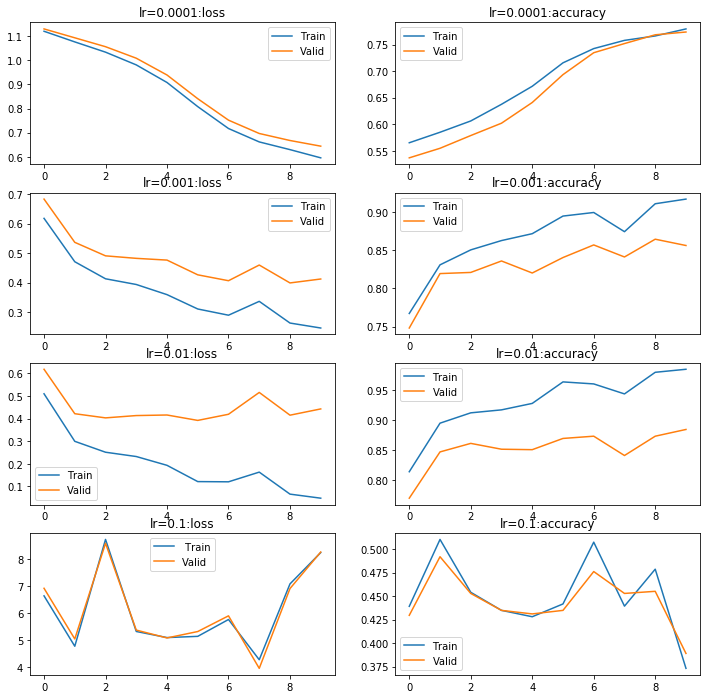

In [ ]:
Figure = plt.figure(figsize=(12,12))
ax1 = Figure.add_subplot(4,2,1)
ax2 = Figure.add_subplot(4,2,2)
ax3 = Figure.add_subplot(4,2,3)
ax4 = Figure.add_subplot(4,2,4)
ax5 = Figure.add_subplot(4,2,5)
ax6 = Figure.add_subplot(4,2,6)
ax7 = Figure.add_subplot(4,2,7)
ax8 = Figure.add_subplot(4,2,8)

for cnt, lr in enumerate(LR):
    print("lr:", lr)
    model = RNN(vocab_size, emb_size, hidden_size, output_size)
    for word, word_id in word2id.items():
        if word in model_gm:
            model.emb.weight.data[word_id] = torch.tensor(model_gm[word])
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr)
    record_loss_train, record_loss_valid, record_acc_train, record_acc_valid = train(model, train_dataset, valid_dataset, 10, batch_size[0], optimizer, criterion, device, collate_fn=Padsequence(len(set(word2id.values()))))
    if cnt == 0:
        ax1.plot(range(len(record_loss_train)), record_loss_train, label="Train")
        ax1.plot(range(len(record_loss_valid)), record_loss_valid, label="Valid")
        ax2.plot(range(len(record_acc_train)), record_acc_train, label="Train")
        ax2.plot(range(len(record_acc_valid)), record_acc_valid, label="Valid")
        ax1.set_title("lr={}:loss".format(lr))
        ax2.set_title("lr={}:accuracy".format(lr))
        ax1.legend()
        ax2.legend()
    elif cnt == 1:
        ax3.plot(range(len(record_loss_train)), record_loss_train, label="Train")
        ax3.plot(range(len(record_loss_valid)), record_loss_valid, label="Valid")
        ax4.plot(range(len(record_acc_train)), record_acc_train, label="Train")
        ax4.plot(range(len(record_acc_valid)), record_acc_valid, label="Valid")
        ax3.set_title("lr={}:loss".format(lr))
        ax4.set_title("lr={}:accuracy".format(lr))
        ax3.legend()
        ax4.legend()
    elif cnt == 2:
        ax5.plot(range(len(record_loss_train)), record_loss_train, label="Train")
        ax5.plot(range(len(record_loss_valid)), record_loss_valid, label="Valid")
        ax6.plot(range(len(record_acc_train)), record_acc_train, label="Train")
        ax6.plot(range(len(record_acc_valid)), record_acc_valid, label="Valid")
        ax5.set_title("lr={}:loss".format(lr))
        ax6.set_title("lr={}:accuracy".format(lr))
        ax5.legend()
        ax6.legend()
    elif cnt == 3:
        ax7.plot(range(len(record_loss_train)), record_loss_train, label=" Train")
        ax7.plot(range(len(record_loss_valid)), record_loss_valid, label="Valid")
        ax8.plot(range(len(record_acc_train)), record_acc_train, label="Train")
        ax8.plot(range(len(record_acc_valid)), record_acc_valid, label="Valid")
        ax7.set_title("lr={}:loss".format(lr))
        ax8.set_title("lr={}:accuracy".format(lr))
        ax7.legend()
        ax8.legend()
plt.show()

lr: 0.0001
batch_size:8
epoch:1 epoch:2 epoch:3 epoch:4 epoch:5 epoch:6 epoch:7 epoch:8 epoch:9 epoch:10
lr: 0.001
batch_size:8
epoch:1 epoch:2 epoch:3 epoch:4 epoch:5 epoch:6 epoch:7 epoch:8 epoch:9 epoch:10
lr: 0.01
batch_size:8
epoch:1 epoch:2 epoch:3 epoch:4 epoch:5 epoch:6 epoch:7 epoch:8 epoch:9 epoch:10
lr: 0.1
batch_size:8
epoch:1 epoch:2 epoch:3 epoch:4 epoch:5 epoch:6 epoch:7 epoch:8 epoch:9 epoch:10


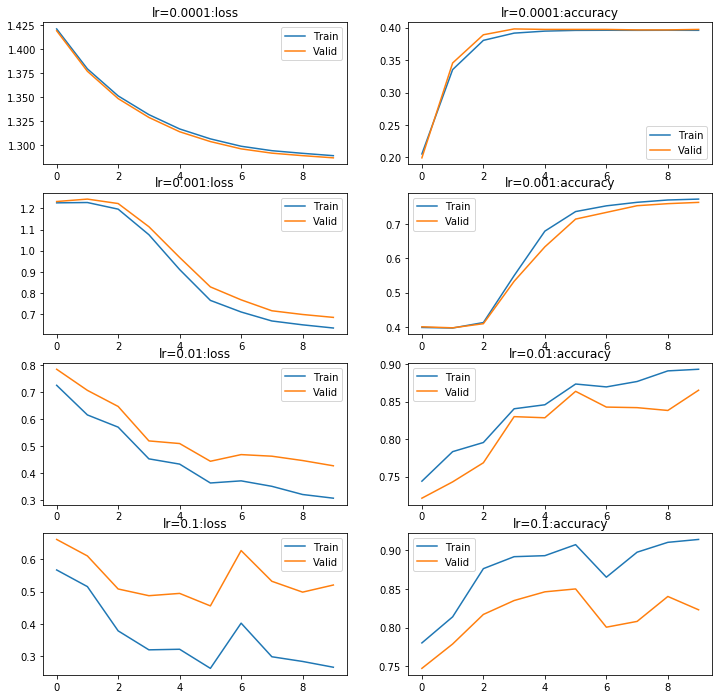

In [ ]:
Figure = plt.figure(figsize=(12,12))
ax1 = Figure.add_subplot(4,2,1)
ax2 = Figure.add_subplot(4,2,2)
ax3 = Figure.add_subplot(4,2,3)
ax4 = Figure.add_subplot(4,2,4)
ax5 = Figure.add_subplot(4,2,5)
ax6 = Figure.add_subplot(4,2,6)
ax7 = Figure.add_subplot(4,2,7)
ax8 = Figure.add_subplot(4,2,8)

for cnt, lr in enumerate(LR):
    print("lr:", lr)
    model = RNN(vocab_size, emb_size, hidden_size, output_size)
    for word, word_id in word2id.items():
        if word in model_gm:
            model.emb.weight.data[word_id] = torch.tensor(model_gm[word])
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr)
    record_loss_train, record_loss_valid, record_acc_train, record_acc_valid = train(model, train_dataset, valid_dataset, 10, batch_size[1], optimizer, criterion, device, collate_fn=Padsequence(len(set(word2id.values()))))
    if cnt == 0:
        ax1.plot(range(len(record_loss_train)), record_loss_train, label="Train")
        ax1.plot(range(len(record_loss_valid)), record_loss_valid, label="Valid")
        ax2.plot(range(len(record_acc_train)), record_acc_train, label="Train")
        ax2.plot(range(len(record_acc_valid)), record_acc_valid, label="Valid")
        ax1.set_title("lr={}:loss".format(lr))
        ax2.set_title("lr={}:accuracy".format(lr))
        ax1.legend()
        ax2.legend()
    elif cnt == 1:
        ax3.plot(range(len(record_loss_train)), record_loss_train, label="Train")
        ax3.plot(range(len(record_loss_valid)), record_loss_valid, label="Valid")
        ax4.plot(range(len(record_acc_train)), record_acc_train, label="Train")
        ax4.plot(range(len(record_acc_valid)), record_acc_valid, label="Valid")
        ax3.set_title("lr={}:loss".format(lr))
        ax4.set_title("lr={}:accuracy".format(lr))
        ax3.legend()
        ax4.legend()
    elif cnt == 2:
        ax5.plot(range(len(record_loss_train)), record_loss_train, label="Train")
        ax5.plot(range(len(record_loss_valid)), record_loss_valid, label="Valid")
        ax6.plot(range(len(record_acc_train)), record_acc_train, label="Train")
        ax6.plot(range(len(record_acc_valid)), record_acc_valid, label="Valid")
        ax5.set_title("lr={}:loss".format(lr))
        ax6.set_title("lr={}:accuracy".format(lr))
        ax5.legend()
        ax6.legend()
    elif cnt == 3:
        ax7.plot(range(len(record_loss_train)), record_loss_train, label="Train")
        ax7.plot(range(len(record_loss_valid)), record_loss_valid, label="Valid")
        ax8.plot(range(len(record_acc_train)), record_acc_train, label="Train")
        ax8.plot(range(len(record_acc_valid)), record_acc_valid, label="Valid")
        ax7.set_title("lr={}:loss".format(lr))
        ax8.set_title("lr={}:accuracy".format(lr))
        ax7.legend()
        ax8.legend()
plt.show()

lr: 0.0001
batch_size:128
epoch:1 epoch:2 epoch:3 epoch:4 epoch:5 epoch:6 epoch:7 epoch:8 epoch:9 epoch:10
lr: 0.001
batch_size:128
epoch:1 epoch:2 epoch:3 epoch:4 epoch:5 epoch:6 epoch:7 epoch:8 epoch:9 epoch:10
lr: 0.01
batch_size:128
epoch:1 epoch:2 epoch:3 epoch:4 epoch:5 epoch:6 epoch:7 epoch:8 epoch:9 epoch:10
lr: 0.1
batch_size:128
epoch:1 epoch:2 epoch:3 epoch:4 epoch:5 epoch:6 epoch:7 epoch:8 epoch:9 epoch:10


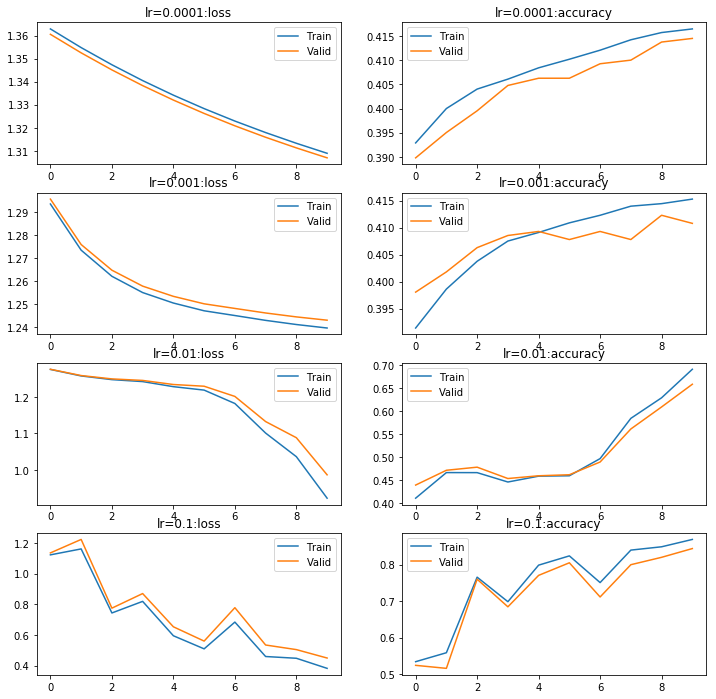

In [ ]:
Figure = plt.figure(figsize=(12,12))
ax1 = Figure.add_subplot(4,2,1)
ax2 = Figure.add_subplot(4,2,2)
ax3 = Figure.add_subplot(4,2,3)
ax4 = Figure.add_subplot(4,2,4)
ax5 = Figure.add_subplot(4,2,5)
ax6 = Figure.add_subplot(4,2,6)
ax7 = Figure.add_subplot(4,2,7)
ax8 = Figure.add_subplot(4,2,8)

for cnt, lr in enumerate(LR):
    print("lr:", lr)
    model = RNN(vocab_size, emb_size, hidden_size, output_size)
    for word, word_id in word2id.items():
        if word in model_gm:
            model.emb.weight.data[word_id] = torch.tensor(model_gm[word])
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr)
    record_loss_train, record_loss_valid, record_acc_train, record_acc_valid = train(model, train_dataset, valid_dataset, 10, batch_size[2], optimizer, criterion, device, collate_fn=Padsequence(len(set(word2id.values()))))
    if cnt == 0:
        ax1.plot(range(len(record_loss_train)), record_loss_train, label="Train")
        ax1.plot(range(len(record_loss_valid)), record_loss_valid, label="Valid")
        ax2.plot(range(len(record_acc_train)), record_acc_train, label="Train")
        ax2.plot(range(len(record_acc_valid)), record_acc_valid, label="Valid")
        ax1.set_title("lr={}:loss".format(lr))
        ax2.set_title("lr={}:accuracy".format(lr))
        ax1.legend()
        ax2.legend()
    elif cnt == 1:
        ax3.plot(range(len(record_loss_train)), record_loss_train, label="Train")
        ax3.plot(range(len(record_loss_valid)), record_loss_valid, label="Valid")
        ax4.plot(range(len(record_acc_train)), record_acc_train, label="Train")
        ax4.plot(range(len(record_acc_valid)), record_acc_valid, label="Valid")
        ax3.set_title("lr={}:loss".format(lr))
        ax4.set_title("lr={}:accuracy".format(lr))
        ax3.legend()
        ax4.legend()
    elif cnt == 2:
        ax5.plot(range(len(record_loss_train)), record_loss_train, label="Train")
        ax5.plot(range(len(record_loss_valid)), record_loss_valid, label="Valid")
        ax6.plot(range(len(record_acc_train)), record_acc_train, label="Train")
        ax6.plot(range(len(record_acc_valid)), record_acc_valid, label="Valid")
        ax5.set_title("lr={}:loss".format(lr))
        ax6.set_title("lr={}:accuracy".format(lr))
        ax5.legend()
        ax6.legend()
    elif cnt == 3:
        ax7.plot(range(len(record_loss_train)), record_loss_train, label="Train")
        ax7.plot(range(len(record_loss_valid)), record_loss_valid, label="Valid")
        ax8.plot(range(len(record_acc_train)), record_acc_train, label="Train")
        ax8.plot(range(len(record_acc_valid)), record_acc_valid, label="Valid")
        ax7.set_title("lr={}:loss".format(lr))
        ax8.set_title("lr={}:accuracy".format(lr))
        ax7.legend()
        ax8.legend()
plt.show()

## 89. 事前学習済み言語モデルからの転移学習
事前学習済み言語モデル（例えばBERTなど）を出発点として，ニュース記事見出しをカテゴリに分類するモデルを構築せよ．

参考 https://htomblog.com/python-bert

In [3]:
train = pd.read_csv("/content/drive/MyDrive/NLP100Knock/data/train.txt", header=None, sep="\t")
valid = pd.read_csv("/content/drive/MyDrive/NLP100Knock/data/valid.txt", header=None, sep="\t")
test = pd.read_csv("/content/drive/MyDrive/NLP100Knock/data/test.txt", header=None, sep="\t")

In [4]:
train = train.set_axis(["text", "target"], axis=1)
valid = valid.set_axis(["text", "target"], axis=1)
test = test.set_axis(["text", "target"], axis=1)

In [5]:
valid

,text,target
0,China's IBM Scrutiny Highlights High Stakes in...,b
1,Kim Kardashian confirms wedding will NOT be te...,e
2,Amazon under investigation after worker was cr...,b
3,"Lesbian, gay, and bisexual Americans more like...",m
4,'Noah' Film Receives Praise From Christian Eva...,e
...,...,...
1329,Scarlett Johansson - Scarlett Johansson teases...,e
1330,Have scientists discovered the first EXOMOON? ...,t
1331,Jenny McCarthy Claims She Is 'Pro-Vaccine' In ...,m
1332,Melissa McCarthy's children have changed her life,e


In [6]:
import re
def cleaning(text):
    text = re.sub("\n", " ", text) # 改行削除
    text = re.sub("[^A-Za-z0-9]", " ", text) # 記号削除
    text = re.sub("[' ']+", " ", text) # スペース統一
    return text.lower() # 小文字で出力

In [7]:
category_dict = {'b': 0, 't': 1, 'e':2, 'm':3}
train["cleaned_text"] = train["text"].map(cleaning)
valid["cleaned_text"] = valid["text"].map(cleaning)
test["cleaned_text"] = test["text"].map(cleaning)
train["target"] = train["target"].map(category_dict)
valid["target"] = valid["target"].map(category_dict)
test["target"] = test["target"].map(category_dict)

In [8]:
train

,text,target,cleaned_text
0,Fitch Lowers South Africa Credit-Rating Outloo...,0,fitch lowers south africa credit rating outloo...
1,FOREX-Dollar rises on US rate speculation afte...,0,forex dollar rises on us rate speculation afte...
2,UPDATE 2-Mexico's lower house generally approv...,0,update 2 mexico s lower house generally approv...
3,U.S. Navy SEALs take control of North Korean-f...,0,u s navy seals take control of north korean fl...
4,Beyonce - Beyonce And Jay Z Pay Tribute To Mic...,2,beyonce beyonce and jay z pay tribute to micha...
...,...,...,...
10667,"Fashion Designers Dolce, Gabbana Lose Appeal o...",2,fashion designers dolce gabbana lose appeal of...
10668,UPDATE 2-Draghi says ECB poised to shore up ec...,0,update 2 draghi says ecb poised to shore up ec...
10669,Bank Austria may sell Ukraine unit within a ye...,0,bank austria may sell ukraine unit within a ye...
10670,The Voice's Blake Shelton shares Adam Levine's...,2,the voice s blake shelton shares adam levine s...


In [9]:
import torch
from torch.utils.data import Dataset, DataLoader

class Data(Dataset):
    def __init__(self, data):
        super().__init__()
        self.data = data
    
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, idx):
        text = self.data["cleaned_text"].values[idx]
        label = self.data["target"].values[idx]
        return text, torch.tensor(label, dtype = torch.float)

In [10]:
train_ds = Data(train)
valid_ds = Data(valid)
train_dl = DataLoader(train_ds, batch_size = 32, shuffle = True, drop_last = True)
valid_dl = DataLoader(valid_ds, batch_size = 32 * 2, shuffle = False, drop_last = False)

In [12]:
!pip install transformers -q

     |████████████████████████████████| 4.4 MB 7.9 MB/s 
     |████████████████████████████████| 596 kB 51.9 MB/s 
     |████████████████████████████████| 101 kB 11.5 MB/s 
     |████████████████████████████████| 6.6 MB 60.4 MB/s 


In [13]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

In [14]:
text = train["cleaned_text"].values[0]
encoded = tokenizer.encode_plus(text)
print(encoded.keys())


dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])


In [15]:
print(len(encoded["input_ids"]))
print(encoded["input_ids"])

11
[101, 26062, 24950, 2148, 3088, 4923, 5790, 17680, 2000, 4997, 102]


In [16]:
input_ids = encoded["input_ids"]
print(input_ids)
decoded = tokenizer.decode(input_ids)
print(decoded)

[101, 26062, 24950, 2148, 3088, 4923, 5790, 17680, 2000, 4997, 102]
[CLS] fitch lowers south africa credit rating outlook to negative [SEP]


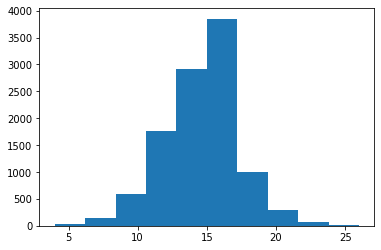

In [17]:
import matplotlib.pyplot as plt

length = []
for text in train["cleaned_text"].values:
    encoded = tokenizer.encode_plus(text.lower())
    length.append(len(encoded["input_ids"]))
plt.hist(length)
plt.show()

In [18]:
import numpy as np
length = np.array(length)
print(np.quantile(length, q = 0.5))
print(np.quantile(length, q = 0.75))
print(np.quantile(length, q = 1))

14.0
16.0
26


In [19]:
MAX_LEN = 26
encoded = tokenizer.encode_plus(text, padding = "max_length", max_length = MAX_LEN, truncation = True)
print(len(encoded["input_ids"]))
print(encoded["attention_mask"][:10])
print(encoded["attention_mask"][-10:])

26
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [20]:
print(tokenizer.decode(encoded["input_ids"]))

[CLS] tupac shakur s final words were f k you other famous last words [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


In [21]:
for key in encoded.keys():
    print(key)
    print(encoded[key])
    print(len(encoded[key]))
    print("=" * 100)

input_ids
[101, 10722, 19498, 21146, 18569, 1055, 2345, 2616, 2020, 1042, 1047, 2017, 2060, 3297, 2197, 2616, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0]
26
token_type_ids
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
26
attention_mask
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
26


In [22]:
from torch import nn
from transformers import AutoModel

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.bert = AutoModel.from_pretrained("bert-base-uncased")
        self.classifier = nn.Linear(in_features = 768, out_features = 4)
    
    def forward(self, input_ids, attention_mask, token_type_ids):
        outputs = self.bert(input_ids = input_ids, attention_mask = attention_mask, token_type_ids = token_type_ids)
        pooler_output = outputs.pooler_output
        logits = self.classifier(pooler_output).squeeze(-1)
        return logits

In [23]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = Model().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)
criterion = nn.CrossEntropyLoss()

best_loss = np.inf # 無限大
for epoch in range(5):
    model.train()
    train_loss = 0
    for batch in train_dl:
        optimizer.zero_grad()
        text = batch[0]
        label = batch[1].long().to(device)
        encoded = tokenizer.batch_encode_plus(
            list(text),
            padding = "max_length",
            max_length = MAX_LEN,
            truncation = True,
            return_tensors = "pt",
            return_attention_mask = True,
            return_token_type_ids = True
            )
        input_ids = encoded["input_ids"].to(device)
        attention_mask = encoded["attention_mask"].to(device)
        token_type_ids = encoded["token_type_ids"].to(device)
        preds = model(input_ids, attention_mask, token_type_ids)
        loss = criterion(preds, label)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_dl)

    model.eval()
    valid_loss = 0
    with torch.no_grad():
        for batch in valid_dl:
            text = batch[0]
            label = batch[1].long().to(device)
            encoded = tokenizer.batch_encode_plus(
                list(text),
                padding = "max_length",
                max_length = MAX_LEN,
                truncation = True,
                return_tensors = "pt",
                return_attention_mask = True,
                return_token_type_ids = True
                )
            input_ids = encoded["input_ids"].to(device)
            attention_mask = encoded["attention_mask"].to(device)
            token_type_ids = encoded["token_type_ids"].to(device)
            preds = model(input_ids, attention_mask, token_type_ids)
            loss = criterion(preds, label)
            valid_loss += loss.item()
        valid_loss /= len(valid_dl)

    print(f"EPOCH[{epoch}]")
    print(train_loss)
    print(valid_loss)
    if valid_loss < best_loss:
        best_loss = valid_loss
        torch.save(model.state_dict(), "bert.pth")
        print("saved ...")

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


EPOCH[0]
0.3404584473205937
0.21265595583688646
saved ...
EPOCH[1]
0.1589649190158547
0.24762627163103648
EPOCH[2]
0.11744076142915422
0.23538276588632948
EPOCH[3]
0.07044644206384751
0.24033725084293456
EPOCH[4]
0.0457482248102105
0.25697390344880877


5分で終わった

In [24]:
model.load_state_dict(torch.load("bert.pth", map_location = "cpu")) # 重みの読み込み
model.eval()
oof = []
with torch.no_grad():
    for batch in valid_dl:
        text = batch[0]
        encoded = tokenizer.batch_encode_plus(
            list(text),
            padding = "max_length",
            max_length = MAX_LEN,
            truncation = True,
            return_tensors = "pt",
            return_attention_mask = True,
            return_token_type_ids = True
            )
        input_ids = encoded["input_ids"].cuda()
        attention_mask = encoded["attention_mask"].cuda()
        token_type_ids = encoded["token_type_ids"].cuda()
        preds = model(input_ids, attention_mask, token_type_ids)
        oof.append(preds.cpu().numpy()) # 予測結果を入れる。cpuデータにする。
oof = np.concatenate(oof, axis = 0) # 予測結果を１次元にまとめる

In [25]:
print(oof.argmax(axis = 1)[:20])
print("=" * 100)
print(valid["target"].values[:20])

[0 2 0 3 2 2 0 0 1 2 0 2 2 3 2 2 1 1 2 0]
[0 2 0 3 2 2 0 0 1 2 1 2 2 3 2 2 1 1 2 0]


In [26]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(valid["target"], oof.argmax(axis = 1))
print(acc)

0.9347826086956522


BERT使えばいいじゃん・・・